# Grafici sui dati sul Corona Virus
## Se non vuoi vedere il codice, vai in basso e troverai le figure

Qui ci andrebbe una introduzione degna di questo nome xxx xxx xxxx

Importiamo le librerie necessarie a fare statistiche e grafici

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

Carichiamo i dati, togliamo le righe con valori mancanti e vediamo un'anteprima

In [2]:
df = pd.read_csv('./../publication/provinceArchivioISTAT.csv')
# in alternativa URL diretta:
# https://raw.githubusercontent.com/ondata/covid19italia/master/publication/provinceArchivio.csv

df = df.dropna()

df.sample(5)

,provincia,numero,regione,datetime,codiceISTAT
130,Milano,197.0,LOMBARDIA,2020-03-05,215.0
220,Sondrio,4.0,LOMBARDIA,2020-03-04,14.0
301,Varese,7.0,LOMBARDIA,2020-03-03,12.0
218,Monza Brianza,11.0,LOMBARDIA,2020-03-04,108.0
91,VICENZA,24.0,VENETO,2020-03-06,24.0


## Attenzione
Concentriamoci sulla colonna "numero".
Questa contiene i malati accertati fino a quel giorno, quindi non avrebbe senso sommare le osservazioni precedenti sullo stesso luogo.

Prepariamo una colonna contenente solo i NUOVI contagiati in un certo giorno.

(decommenta i print nel codice per vedere i passaggi uno per uno)

In [3]:
# ordiniamo i dati in base a provincia e giorno
df = df.sort_values(by=['provincia', 'datetime'])

# sottraiamo il numero dei contagiati di un giorno da quelli del giorno precedente
# prima di fare la sottrazione dobbiamo raggruppare per provincia
df['nuovi_contagi'] = df[ ['numero', 'provincia'] ].groupby('provincia').diff()

# esempio
df[ df['provincia'] == 'Milano' ]

,provincia,numero,regione,datetime,codiceISTAT,nuovi_contagi
363,Milano,58.0,LOMBARDIA,2020-03-02,215.0,NaN
297,Milano,93.0,LOMBARDIA,2020-03-03,215.0,35.0
217,Milano,145.0,LOMBARDIA,2020-03-04,215.0,52.0
130,Milano,197.0,LOMBARDIA,2020-03-05,215.0,52.0
42,Milano,267.0,LOMBARDIA,2020-03-06,215.0,70.0


Da adesso in poi ci possiamo distinguere le nostre analisi, tenendo conto degli andamenti `nuovi_contagi` e del numero cumulativo con `numero`.

In [4]:
ultimo_giorno = df['datetime'].max()
df_ultimo_giorno = df[ df['datetime'] == ultimo_giorno ]
totale_contagiati = df_ultimo_giorno['numero'].sum()
print(f'\n\nTotale contagiati al {ultimo_giorno}: {totale_contagiati}')



Totale contagiati al 2020-03-06: 4446.0


## I contagiati per regione, provincia, data

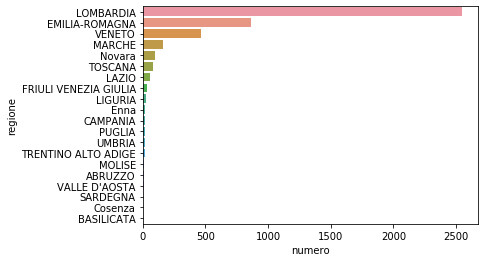

                       numero
regione                      
LOMBARDIA              2544.0
EMILIA-ROMAGNA          867.0
VENETO                  464.0
MARCHE                  159.0
Novara                   99.0
TOSCANA                  79.0
LAZIO                    54.0
FRIULI VENEZIA GIULIA    31.0
LIGURIA                  28.0
Enna                     18.0
CAMPANIA                 17.0
PUGLIA                   17.0
UMBRIA                   16.0
TRENTINO ALTO ADIGE      14.0
MOLISE                   12.0
ABRUZZO                   9.0
VALLE D'AOSTA             7.0
SARDEGNA                  5.0
Cosenza                   3.0
BASILICATA                3.0


In [5]:
df_by_regione = df_ultimo_giorno[ ['regione', 'numero'] ].groupby('regione')
df_by_regione = df_by_regione.sum().sort_values(by='numero', ascending=False)

sns.barplot(data=df_by_regione.reset_index(), x='numero', y='regione')
plt.show()

print(df_by_regione)

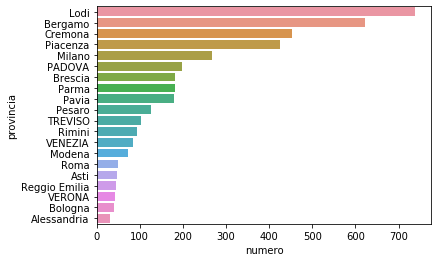

        provincia  numero
40           Lodi   739.0
35        Bergamo   623.0
38        Cremona   452.0
15       Piacenza   426.0
42         Milano   267.0
86         PADOVA   198.0
36        Brescia   182.0
14          Parma   181.0
44          Pavia   180.0
51         Pesaro   126.0
88        TREVISO   103.0
18         Rimini    93.0
89        VENEZIA    85.0
13         Modena    73.0
28           Roma    49.0
54           Asti    47.0
17  Reggio Emilia    44.0
90         VERONA    42.0
10        Bologna    41.0
53    Alessandria    32.0


In [6]:
df_by_provincia = df_ultimo_giorno.sort_values(by='numero', ascending=False)

# prendiamo in considerazione solo le prime 20 più colpite
df_by_provincia = df_by_provincia.head(20)

sns.barplot(data=df_by_provincia, x='numero', y='provincia')
plt.show()

print(df_by_provincia[ ['provincia', 'numero'] ])

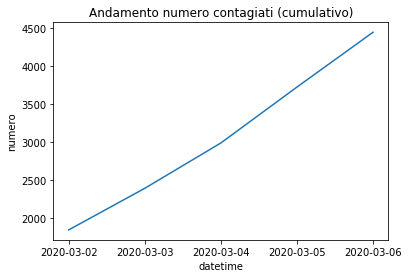

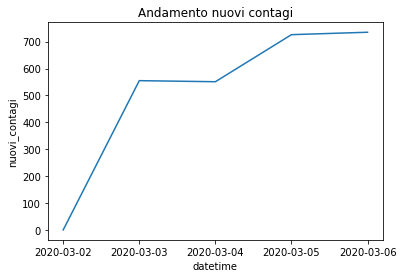

In [7]:
# raggruppa in base al giorno
df_by_datetime = df[ ['datetime', 'numero', 'nuovi_contagi'] ].groupby('datetime')
df_by_datetime = df_by_datetime.sum().sort_values(by='datetime')

# contagi cumulativi
g = sns.lineplot(data=df_by_datetime.reset_index(), x='datetime', y='numero')
g.set_title('Andamento numero contagiati (cumulativo)')
plt.show()

# nuovi contagi
g = sns.lineplot(data=df_by_datetime.reset_index(), x='datetime', y='nuovi_contagi')
g.set_title('Andamento nuovi contagi')
plt.show()


## Mappa dei contagi per provincia

**N.B. bisogna installare:**
* **geopandas**
* **descartes**

In [8]:
df_by_provincia.head()

,provincia,numero,regione,datetime,codiceISTAT,nuovi_contagi
40,Lodi,739.0,LOMBARDIA,2020-03-06,98.0,81.0
35,Bergamo,623.0,LOMBARDIA,2020-03-06,16.0,86.0
38,Cremona,452.0,LOMBARDIA,2020-03-06,19.0,46.0
15,Piacenza,426.0,EMILIA-ROMAGNA,2020-03-06,33.0,48.0
42,Milano,267.0,LOMBARDIA,2020-03-06,215.0,70.0


In [9]:
#!pip install geopandas
#!pip install descartes

In [10]:
import geopandas as gpd

In [11]:
italy = gpd.read_file('./../risorse/prov2019.geojson')

Attenzione! Qui ho fatto *merge* con le denominazioni delle province, potete farlo anche col codice ma và prima convertito in intero.

Imputo 0 ai missing values, ipotizzando che non ci siano stati casi se manca il valore.

In [12]:
italy['DEN_UTS'] = italy['DEN_UTS'].str.lower()
df_by_provincia['provincia'] = df_by_provincia['provincia'].str.lower()
covid19map = italy.merge(df_by_provincia, how = 'left',left_on = 'DEN_UTS', right_on = 'provincia')
covid19map['numero'].fillna(0, inplace = True)

Costruisco la variabile *covid19 rate*, non è altro che la percentuale di casi per provincia (calcolata su tutti i casi italiani).

In [13]:
covid19map['covid19 rate'] = covid19map['numero']/covid19map['numero'].sum()

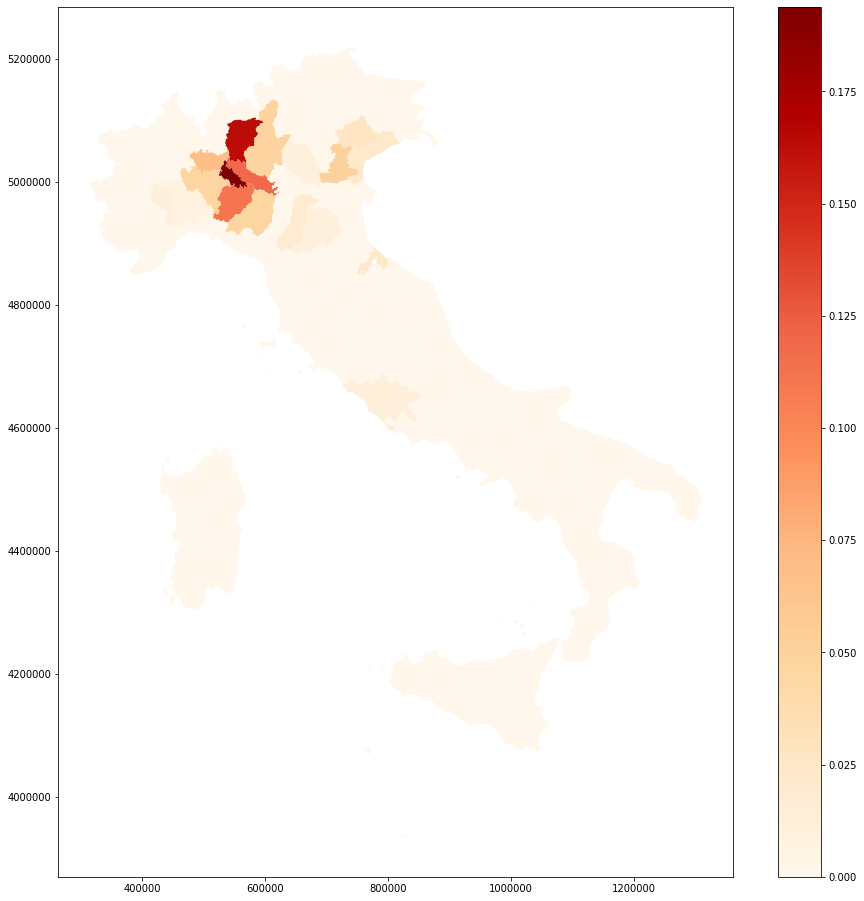

In [14]:
fig, ax = plt.subplots(1, figsize=(16, 16))
covid19map.plot(column='covid19 rate', ax=ax, cmap='OrRd', legend=True)
plt.show()